# **BitPredict**

## Time series forecasting in TensorFlow

Building a series of models in an attempt to predict the price of Bitcoin. 

Steps:

* Get time series data (the historical price of Bitcoin)
  * Load in time series data using pandas/Python's CSV module

* Format data for a time series problem
  * Creating training and test sets
  * Visualizing time series data
  * Turning time series data into a supervised learning problem (windowing)
  * Preparing univariate and multivariate data

* Evaluating a time series forecasting model

* Setting up a series of deep learning modelling experiments
  * Dense (fully-connected) networks
  * Sequence models (LSTM and 1D CNN)
  * Ensembling (combining multiple models together)
  * Multivariate models
  * Replicating the N-BEATS algorithm using TensorFlow layer subclassing

* Creating a modelling checkpoint to save the best performing model during training

* Making predictions (forecasts) with a time series model

* Creating prediction intervals for time series model forecasts

* Discussing two different types of uncertainty in machine learning 
(data uncertainty and model uncertainty)

* Demonstrating why forecasting in an open system is BS (the turkey problem) 


In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np

In [2]:
# Check for GPU
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## Data





In [3]:
# Download data from GitHub 

!wget https://raw.githubusercontent.com/iMonk0910/100daysofML/main/Deep_Learning/TensorFlow_Developer_Zero_to_Mastery/project3/bitcoin_data.csv

--2022-10-15 16:38:22--  https://raw.githubusercontent.com/iMonk0910/100daysofML/main/Deep_Learning/TensorFlow_Developer_Zero_to_Mastery/project3/bitcoin_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 175721 (172K) [text/plain]
Saving to: ‘bitcoin_data.csv’

bitcoin_data.csv    100%[===================>] 171.60K  --.-KB/s    in 0.02s   

2022-10-15 16:38:22 (7.08 MB/s) - ‘bitcoin_data.csv’ saved [175721/175721]



In [4]:
df = pd.read_csv("/content/bitcoin_data.csv", 
                 parse_dates=["Date"], 
                 index_col=["Date"]) 
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [6]:
len(df)

2787

In [7]:
# closing price for each day 
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


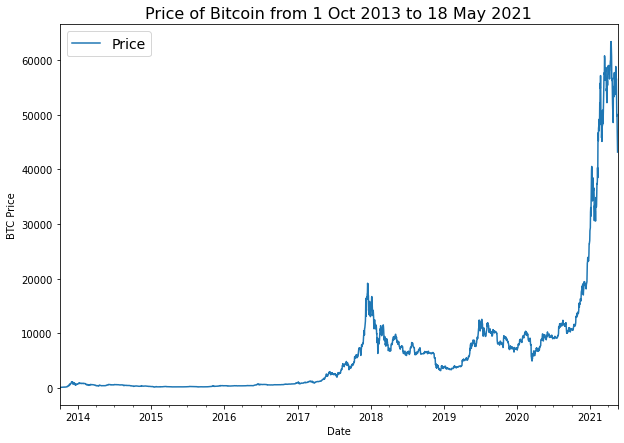

In [8]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);

## Creating train and test sets for time series data

What *kind* of data we have.

**univariate** or **multivariate** data.

* **Univariate** time series data deals with *one* variable, for example, using the price of Bitcoin to predict the price of Bitcoin.

* **Multivariate** time series data deals with *more than one* variable, for example, predicting electricity demand using the day of week, time of year and number of houses in a region.



Here we're dealing with a univariate time series, so we only have to make a split on one variable (for multivariate time series, you will have to split multiple variables). 

![time series train test split](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-time-series-train-test-split.png)

it's best to split the time series data sequentially. Meaning, the test data should be data from the future when compared to the training data.*

In [9]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [10]:
# Create train and test splits 
split_size = int(0.8 * len(prices)) # 80% train, 20% test

X_train, y_train = timesteps[:split_size], prices[:split_size]

X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

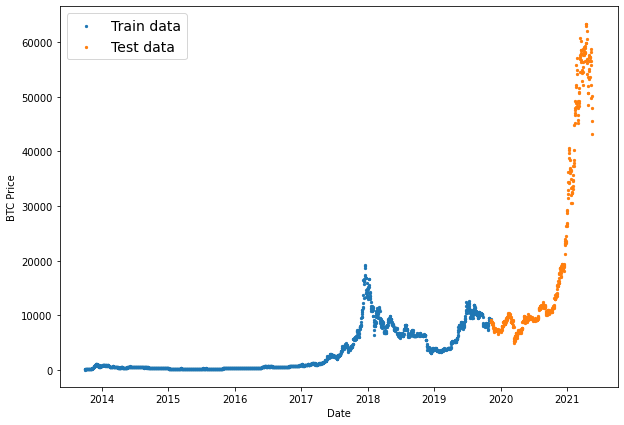

In [11]:
# Plot 
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

### Create a plotting function


In [12]:
# Function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
 
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) 
  plt.grid(True)

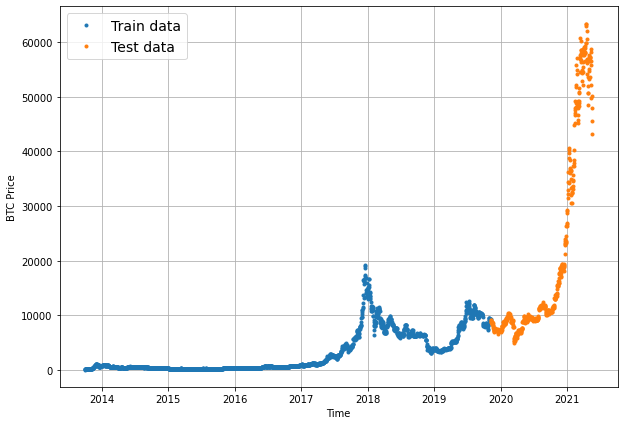

In [13]:
# Plotting with function
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

## Model 0: Naïve forecast (baseline)


That's because all the naïve model does is use the previous timestep value to predict the next timestep value.


$$\hat{y}_{t} = y_{t-1}$$ 



In [14]:

# Create a naïve forecast
naive_forecast = y_test[:-1] # Naïve forecast equals every value excluding the last value
naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

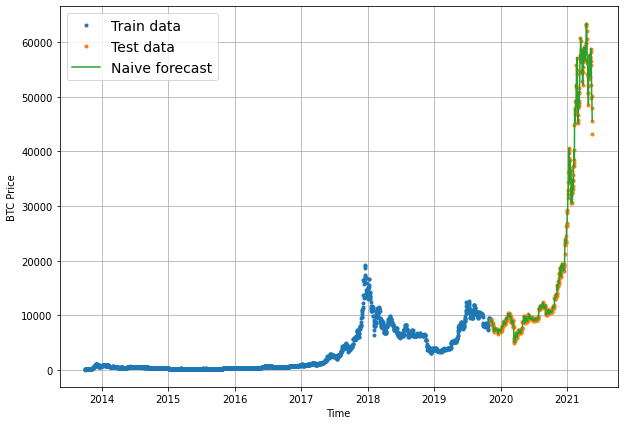

In [15]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive forecast");

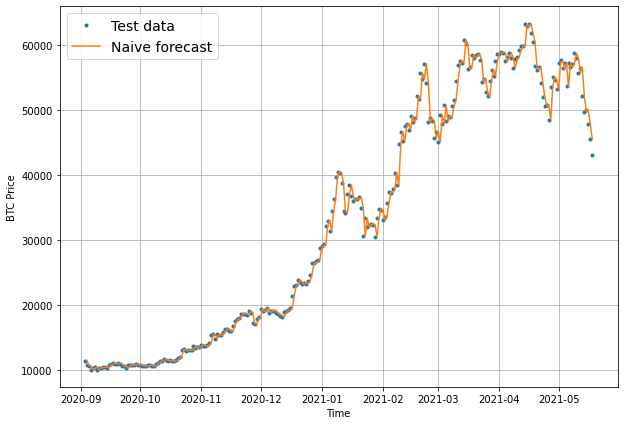

In [16]:
plt.figure(figsize=(10, 7))
offset = 300 # offset the values by 300 timesteps 
plot_time_series(timesteps=X_test, values=y_test, start=offset, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", start=offset, label="Naive forecast");

Naïve forecast comes slightly after the test data, because the naive forecast uses the previous timestep value to predict the next timestep value.


## Evaluating a time series model



In [17]:
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_naive_no_season

In [18]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)
  
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [19]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

In [20]:
# Find average price of Bitcoin in test dataset
tf.reduce_mean(y_test).numpy()

20056.632963737226

* The average price of Bitcoin in the test dataset is: $20,056 (note: average may not be the best measure here, since the highest price is over 3x this value and the lowest price is over 4x lower)

* Each prediction in naive forecast is on average off by: $567


## Windowing dataset


Windowing is a method to turn a time series dataset into **supervised learning problem**. 

For example for a univariate time series, windowing for one week (`window=7`) to predict the next single value (`horizon=1`) might look like:

```
Window for one week (univariate time series)

[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

```
Window for one week with the target of predicting the next day (Bitcoin prices)

[123.654, 125.455, 108.584, 118.674, 121.338, 120.655, 121.795] -> [123.033]
[125.455, 108.584, 118.674, 121.338, 120.655, 121.795, 123.033] -> [124.049]
[108.584, 118.674, 121.338, 120.655, 121.795, 123.033, 124.049] -> [125.961]
```

In [21]:
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 7 # 7 days timesteps to predict the horizon

In [22]:
# Function to label windowed data
def get_labelled_windows(x, horizon=1):
  
  return x[:, :-horizon], x[:, -horizon:]

In [23]:
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


In [24]:
def make_windows(x, window_size=7, horizon=1):
  

  # 1. Create a window of specific window_size
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)

  # 2. 2D array of multiple window steps
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T

  # 3. Target array
  windowed_array = x[window_indexes]

  # 4. Labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [25]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [26]:
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


In [27]:
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Label: [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Label: [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Label: [43144.47129086]


In [28]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):

  split_size = int(len(windows) * (1-test_split))
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [29]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [30]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]), array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [31]:
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

## Modelling checkpoint


In [32]:
import os

# Function to implement a ModelCheckpoint callback
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            verbose=0, 
                                            save_best_only=True) 

## Model 1: Dense model (window = 7, horizon = 1)

`model_1`

* A single dense layer with 128 hidden units and ReLU (rectified linear unit) activation
* An output layer with linear activation (or no activation)
* Adam optimizer and MAE loss function
* Batch size of 128
* 100 epochs

In [33]:
from tensorflow.keras import layers

tf.random.set_seed(42)

# Create model 
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear")                    
], name="model_1_dense") 

# Compile model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"]) 

# Fit model
model_1.fit(x=train_windows, 
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
18/18 [==============================] - 2s 50ms/step - loss: 780.3469 - mae: 780.3469 - val_loss: 2279.5828 - val_mae: 2279.5828
Epoch 2/100
18/18 [==============================] - 1s 33ms/step - loss: 247.6765 - mae: 247.6765 - val_loss: 1005.9865 - val_mae: 1005.9865
Epoch 3/100
18/18 [==============================] - 1s 32ms/step - loss: 188.4107 - mae: 188.4107 - val_loss: 923.2861 - val_mae: 923.2861
Epoch 4/100
18/18 [==============================] - 1s 35ms/step - loss: 169.4334 - mae: 169.4334 - val_loss: 900.5931 - val_mae: 900.5931
Epoch 5/100
18/18 [==============================] - 1s 31ms/step - loss: 165.0900 - mae: 165.0900 - val_loss: 895.2404 - val_mae: 895.2404
Epoch 6/100
18/18 [==============================] - 1s 30ms/step - loss: 158.5206 - mae: 158.5206 - val_loss: 855.1868 - val_mae: 855.1868
Epoch 7/100
18/18 [==============================] - 1s 32ms/step - loss: 151.3568 - mae: 151.3568 - val_loss: 840.9289 - val_mae: 840.9289
Epoch 8/100
18/1

In [34]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 662.5322 - mae: 662.5322


[662.5322265625, 662.5322265625]

In [35]:
# Evaluate on test data
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 568.5499 - mae: 568.5499


[568.5498657226562, 568.5498657226562]

## Making forecasts with a model (on the test dataset)

We've trained a model and evaluated the it on the test data, but the project we're working on is called BitPredict 💰📈 so how do you think we could use our model to make predictions?

Since we're going to be running more modelling experiments, let's write a function which: 
1. Takes in a trained model (just like `model_1`)
2. Takes in some input data (just like the data the model was trained on) 
3. Passes the input data to the model's `predict()` method
4. Returns the predictions



In [36]:
def make_preds(model, input_data):
  
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [37]:
# Make predictions using model_1 
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

18/18 [==============================] - 0s 2ms/step


(556, <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8874.493, 8789.944, 9040.986, 8804.829, 8741.21 , 8749.837,
        8705.865, 8513.171, 8478.415, 8536.302], dtype=float32)>)

In [38]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), # reduce to right shape
                                 y_pred=model_1_preds)
model_1_results

{'mae': 568.5498,
 'mse': 1172587.4,
 'rmse': 1082.8607,
 'mape': 2.549229,
 'mase': 0.99878454}

In [39]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

Naïve model beats our first deep model on nearly every metric.



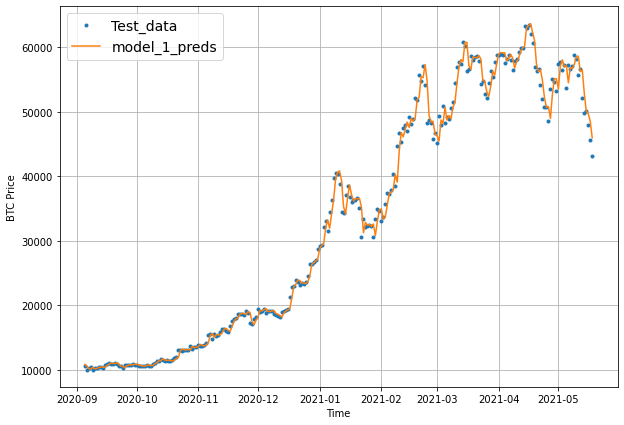

In [40]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="model_1_preds")

## Model 2: Dense (window = 30, horizon = 1)


In [41]:
HORIZON = 1 # predict one step
WINDOW_SIZE = 30 # use 30 timesteps

In [42]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2757, 2757)

In [43]:
# train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [44]:
tf.random.set_seed(42)

model_2 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON) 
], name="model_2_dense")

model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

In [45]:
# Evaluate model 2 preds
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 658.0281


658.028076171875

In [46]:
# Load performing model
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense/")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 608.8478


608.8478393554688

In [47]:
# Forecast predictions
model_2_preds = make_preds(model_2,
                           input_data=test_windows)

18/18 [==============================] - 0s 2ms/step


In [48]:
# Evaluate results
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels), # remove 1 dimension of test labels
                                 y_pred=model_2_preds)
model_2_results

{'mae': 608.84796,
 'mse': 1284313.5,
 'rmse': 1133.2755,
 'mape': 2.7680647,
 'mase': 1.0642722}

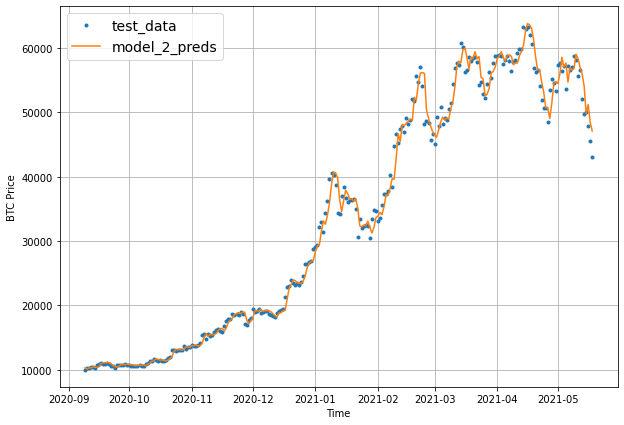

In [49]:
offset = 300
plt.figure(figsize=(10, 7))

plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="model_2_preds") 

## Model 3: Dense (window = 30, horizon = 7)


In [50]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2751, 2751)

In [51]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels, test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [52]:
tf.random.set_seed(42)

model_3 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name="model_3_dense")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

In [53]:
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1297.3754


1297.3753662109375

In [54]:
# Evaluate
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense/")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1236.2075


1236.20751953125

In [55]:
# The predictions 
model_3_preds = make_preds(model_3,
                           input_data=test_windows)
model_3_preds[:5]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[9066.453 , 9334.446 , 9461.401 , 9388.391 , 9463.582 , 9670.427 ,
        9430.584 ],
       [8755.7295, 9083.715 , 9226.223 , 8985.109 , 9058.751 , 9266.0625,
        9211.953 ],
       [8716.3545, 9035.204 , 9130.837 , 8909.687 , 9015.347 , 9136.23  ,
        9121.998 ],
       [8914.29  , 9065.095 , 9077.667 , 9093.83  , 9053.94  , 9326.763 ,
        9151.856 ],
       [8814.659 , 9023.546 , 8928.278 , 8960.1   , 9191.008 , 9366.611 ,
        9029.211 ]], dtype=float32)>

In [56]:
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': array([  608.96844 ,   344.76828 ,   409.33035 ,   471.0399  ,
          490.4255  ,   600.3134  ,   610.6784  ,   538.9532  ,
          574.64154 ,   720.91125 ,   879.78284 ,   808.7538  ,
          791.4953  ,   857.7123  ,   631.0079  ,   285.35532 ,
          179.58748 ,   183.56947 ,   228.9442  ,   271.1052  ,
          128.55656 ,   206.18924 ,   263.39984 ,   323.2526  ,
          214.50551 ,   173.37088 ,   145.38805 ,   160.09402 ,
          177.30022 ,   236.22984 ,   360.91635 ,   425.67856 ,
          324.77322 ,   344.0058  ,   309.53043 ,   309.55023 ,
          367.54547 ,   295.3404  ,   239.49881 ,   156.17683 ,
          346.646   ,    90.05671 ,    98.09535 ,    92.904434,
          143.89754 ,    52.04827 ,   104.60673 ,   144.27791 ,
          152.39607 ,   145.75648 ,   167.4158  ,   183.91566 ,
          230.51297 ,   167.87012 ,   239.78084 ,   313.32846 ,
          494.19455 ,   496.88315 ,   469.7184  ,   481.3379  ,
          394.08463 ,   244.0648 

In [57]:
## Evaluation function larger horizons

def evaluate_preds(y_true, y_pred):
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [58]:
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 1236.2075,
 'mse': 5459194.0,
 'rmse': 1421.6143,
 'mape': 5.5906534,
 'mase': 2.1997616}

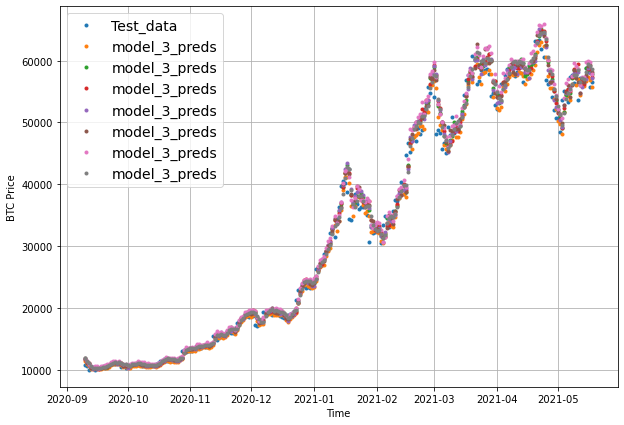

In [59]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")

plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds, start=offset, label="model_3_preds")

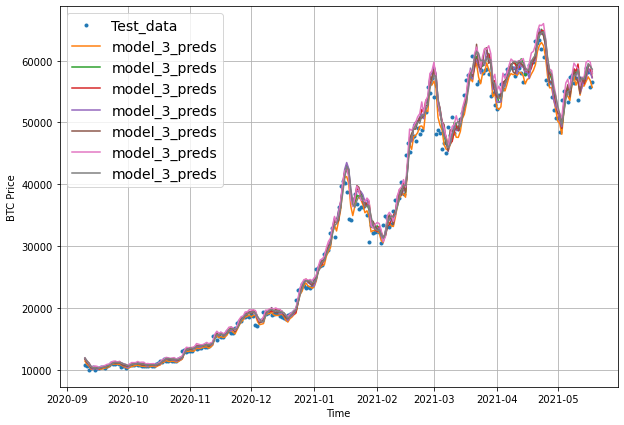

In [60]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0], 
                 start=offset, 
                 label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values= model_3_preds, 
                 format="-",
                 start=offset, 
                 label="model_3_preds")

Trained 3 models which use the same architecture but use different data inputs.

Comparing naïve model with other models

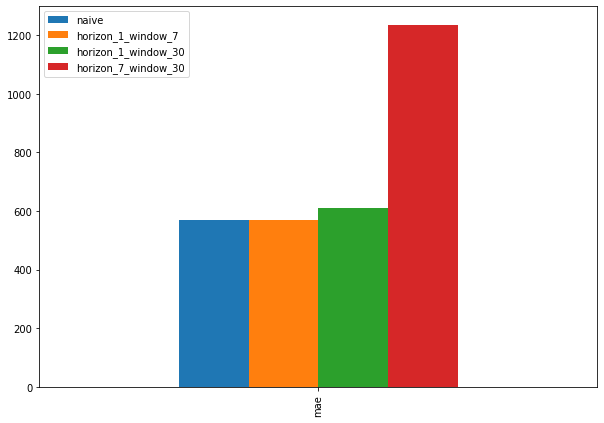

In [61]:
pd.DataFrame({"naive": naive_results["mae"], 
              "horizon_1_window_7": model_1_results["mae"], 
              "horizon_1_window_30": model_2_results["mae"], 
              "horizon_7_window_30": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar");

## Model 4: Conv1D

A Conv1D model for sequence to sequence problems.

Input sequence is the previous 7 days of Bitcoin price data and the output is the next day (in seq2seq terms this is called a many to one problem).

In [62]:
HORIZON = 1 # predict next day
WINDOW_SIZE = 7 # use previous week worth of data

In [63]:
# Create windowed dataset
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [64]:
# Create train/test splits
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [65]:
# Check data sample shapes
train_windows[0].shape # returns (WINDOW_SIZE, )

(7,)

In [66]:
# Reshape datav in order to it works
x = tf.constant(train_windows[0])
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra dimension for timesteps
print(f"Original shape: {x.shape}") # (WINDOW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}") # (WINDOW_SIZE, input_dim) 
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


In [67]:
tf.random.set_seed(42)

# Create model
model_4 = tf.keras.Sequential([
    
  layers.Lambda(lambda x: tf.expand_dims(x, axis=1)), # resize the inputs to adjust for window size / Conv1D 3D input requirements
  layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
  layers.Dense(HORIZON)
], name="model_4_conv1D")

# Compile model
model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit model
model_4.fit(train_windows,
            train_labels,
            batch_size=128, 
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

In [68]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [69]:
# Load Conv1D model and evaluate it on the test data
model_4 = tf.keras.models.load_model("model_experiments/model_4_conv1D")
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 569.0327


569.03271484375

In [70]:
# Make predictions
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8847.293, 8757.502, 8997.469, 8762.801, 8707.723, 8713.595,
       8664.934, 8496.83 , 8439.471, 8499.395], dtype=float32)>

In [71]:
# Evaluate predictions
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

{'mae': 569.0327,
 'mse': 1169841.2,
 'rmse': 1081.592,
 'mape': 2.551526,
 'mase': 0.9996329}

## Model 5: RNN (LSTM)
 








In [72]:
tf.random.set_seed(42)

# LSTM model with the Functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs) # expand input dimension 

x = layers.LSTM(128, activation="relu")(x) 
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_lstm")

# Compile model
model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

#fit model
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

In [73]:
# Load model 5 and evaluate
model_5 = tf.keras.models.load_model("model_experiments/model_5_lstm/")
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 592.9673


592.9673461914062

In [74]:
# Make predictions with our LSTM model
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8928.547, 8771.724, 8981.306, 8785.671, 8692.619, 8763.735,
       8690.13 , 8497.842, 8477.036, 8502.296], dtype=float32)>

In [75]:
# Evaluate model 5 preds
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)
model_5_results

{'mae': 592.96735,
 'mse': 1248880.5,
 'rmse': 1117.5332,
 'mape': 2.6613557,
 'mase': 1.0416794}

## Make a multivariate time series 

Adding an extra feature to our dataset:

Bitcoin block reward size - The Bitcoin block reward size is the number of Bitcoin someone receives from mining a Bitcoin block.

At its inception, the Bitcoin block reward size was 50.

But every four years or so, the Bitcoin block reward halves.

For example, the block reward size went from 50 (starting January 2009) to 25 on November 28 2012.



Adding an extra feature to our dataset such as the Bitcoin block reward size will take our data from **univariate** (only the historical price of Bitcoin) to **multivariate** (the price of Bitcoin as well as the block reward size).

In [76]:
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [77]:
# Block reward values
block_reward_1 = 50 # 3 January 2009 (2009-01-03) - Not in our dataset(starts from 01 October 2013)
block_reward_2 = 25 # 28 November 2012 
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 11 May 2020

# Block reward dates 
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

In [78]:
# Get date indexes for when to add in different block dates
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2414)

In [79]:
# Add block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Set values of block_reward column (it's the last column hence -1 indexing on iloc)
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


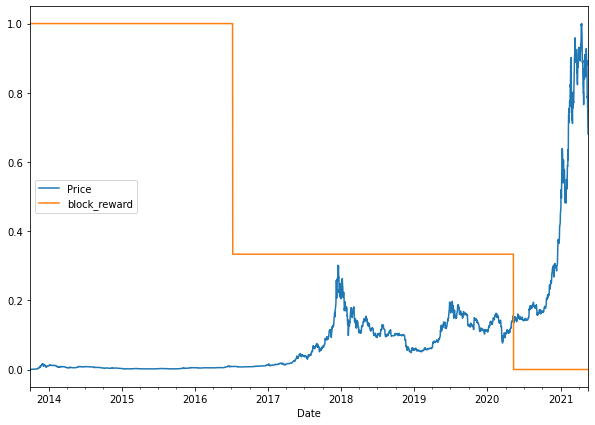

In [80]:
# Plot the block reward/price over time
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]), #  maimax scaler 
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7));

## Making a windowed dataset



In [81]:
# Setup dataset hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE): # Shift values for each step in WINDOW_SIZE
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)  #shift
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [82]:
# Create X & y, remove the NaN's and convert to float32
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32) 
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [83]:
# View labels
y.head()

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
2013-10-11    125.279663
2013-10-12    125.927498
Name: Price, dtype: float32

In [84]:
# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

## Model 6: Dense (multivariate time series)


In [85]:
tf.random.set_seed(42)

model_6 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),

  layers.Dense(HORIZON)
], name="model_6_dense_multivariate")

# Compile
model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_6.fit(X_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=0, # only print 1 line per epoch
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

In [86]:
# load model and evaluate
model_6 = tf.keras.models.load_model("model_experiments/model_6_dense_multivariate")
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 567.8292


567.8291625976562

In [87]:
# Make predictions on multivariate data
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8844.084, 8769.791, 9048.283, 8748.914, 8731.422, 8773.469,
       8670.191, 8502.751, 8471.279, 8529.221], dtype=float32)>

In [88]:
# Evaluate preds
model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

{'mae': 567.82916,
 'mse': 1163727.5,
 'rmse': 1078.762,
 'mape': 2.546015,
 'mase': 0.99751854}

In [89]:
model_1_results

{'mae': 568.5498,
 'mse': 1172587.4,
 'rmse': 1082.8607,
 'mape': 2.549229,
 'mase': 0.99878454}

## Model 7: N-BEATS algorithm


In [90]:
# Create NBeatsBlock custom layer 
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, # hyperparameters for the layer
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs argument for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # n_layers fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): # the call method is what runs when the layer is called 
    x = inputs 
    for layer in self.hidden: # pass inputs through each hidden layer 
      x = layer(x)
    theta = self.theta_layer(x) 
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [91]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE, 
                                       theta_size=WINDOW_SIZE+HORIZON, # backcast + forecast 
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [92]:
# Create dummy inputs (have to be same size as input_size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0) # input shape to the model has to reflect Dense layer input requirements (ndim=2)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [93]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
# Activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [ 0.19014972  0.8379835  -0.32870024  0.2515991  -0.47540277 -0.7783665
 -0.52994466]
Forecast: -0.7554213404655457


In [94]:
# Preparing data for the N-BEATS

HORIZON = 1 # predict forward
WINDOW_SIZE = 7 # lookback

# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.dropna().head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500
2013-10-10,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483
2013-10-11,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466
2013-10-12,125.92750,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866


In [95]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [96]:
# 1. Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

### Setting up hyperparameters for N-BEATS algorithm


Hyperparameters in Figure 1 and Table 18/Appendix D of the [N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf).

![table 18 from N-BEATS paper](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-nbeats-table-18-hyperparameters.png)

Table 18 from [N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf) describing the hyperparameters used for the different variants of N-BEATS.




In [105]:
# Hyperparameter values for N-BEATS
N_EPOCHS = 1000 # as "Iterations" in table
N_NEURONS = 512 # as "Width" in table 
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON # as "Lookback" in Table
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

### Residual stacking

> What is a residual connection?

`A **residual connection** (also called skip connections) involves a deeper neural network layer receiving the outputs as well as the inputs of a shallower neural network layer.`

N-BEATS architecture residual connections layers:

* Subtract the backcast outputs from a previous block from the backcast inputs to the current block
* Add the forecast outputs from all blocks together in a stack

There are two layers to go through which play a large roll in the architecture of N-Beats

[`tf.keras.layers.subtract(inputs)`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/subtract) - subtracts list of input tensors from each other

[`tf.keras.layers.add(inputs)`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/add) - adds list of input tensors to each other


In [107]:
# tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Subtract
subtracted = layers.subtract([tensor_1, tensor_2])

# Add
added = layers.add([tensor_1, tensor_2])

print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


**Residual stacking** or **residual connections** helps to build a deeper but less complex neural network. 

`This deeper neural network led to state of the art results on the ImageNet challenge in 2015 and different versions of residual connections have been present in deep learning ever since.`

 
![N-BEATS architecture double residual stacking](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-nbeats-architecture-double-residual-stacking.png)

`Backcast residuals of each block are subtracted from each other and used as the input to the next block where as the forecasts of each block are added together to become the stack forecast.`


Residual connections have been beneficial for training deeper models (N-BEATS reaches ~150 layers, also see "These approaches provide clear advantages in improving the trainability of deep architectures" in section 3.2 of the [N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf)).  

Helps in avoiding the problem of [vanishing gradients](https://en.wikipedia.org/wiki/Vanishing_gradient_problem) (patterns learned by a neural network not being passed through to deeper layers).



### Building, compiling and fitting the N-BEATS algorithm 

Steps for making N-BEATS algorithm model:

1. Setup an instance of the N-BEATS block layer using `NBeatsBlock` (Initial block for the network and rest will be created as part of stacks)

2. Create an input layer for the N-BEATS stack (Using Keras Functional API)

3. Initial backcast and forecasts for the model with the layer created in (1)

4. Loop to create stacks of block layers

5. Use the NBeatsBlock class within the for loop created in (4) to create blocks which return backcasts and block-level forecasts

6. Create the double residual stacking using subtract and add layers

7. Put the model inputs and outputs together using `tf.keras.Model()

8. Compile the model with MAE loss and Adam optimizer.

9. Fit the N-BEATS model for 1000 epochs with a couple of callbacks:

  * `tf.keras.callbacks.EarlyStopping()` - stop the model from training if it doesn't improve validation loss for 50 epochs and restore the best performing weights using `restore_best_weights=True` (this'll prevent the model from training for long period of time without improvement)

  * `tf.keras.callbacks.ReduceLROnPlateau()` - if the model's validation loss doesn't improve for 20 epochs, reduce the learning rate by 10x to try and help it make incremental improvements (the smaller the learning rate, the smaller updates a model tries to make)



In [108]:
%%time

tf.random.set_seed(42)

# N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# Create input to stacks
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# Create initial backcast and forecast input (backwards predictions are residuals )
backcast, forecast = nbeats_block_layer(stack_input)

# Subtraction residuals
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00") 

# Loop for stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

  # Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}") 
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input, 
                         outputs=forecast, 
                         name="model_7_N-BEATS")

# 8. Compile with MAE loss and Adam optimizer
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=20, verbose=1)])


Epoch 55: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 103: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 123: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
CPU times: user 27min 8s, sys: 41 s, total: 27min 49s
Wall time: 16min 3s


In [109]:
# Evaluate N-BEATS model on the test dataset
model_7.evaluate(test_dataset)

1/1 [==============================] - 0s 473ms/step - loss: 570.5759 - mae: 570.5759 - mse: 1162314.2500


[570.5758666992188, 570.5758666992188, 1162314.25]

In [110]:
# Make predictions with N-BEATS model
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

1/1 [==============================] - 5s 5s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8814.036, 8769.509, 9063.271, 8763.517, 8750.886, 8757.022,
       8645.664, 8510.967, 8469.754, 8527.702], dtype=float32)>

In [111]:
# Evaluate N-BEATS model predictions
model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)
model_7_results

{'mae': 570.57587,
 'mse': 1162314.2,
 'rmse': 1078.1068,
 'mape': 2.5913708,
 'mase': 1.0023438}

It looks like the N-BEATS model doesn't perform as well as `model_1` or the original naive forecast.

### Plotting the N-BEATS architecture we've created



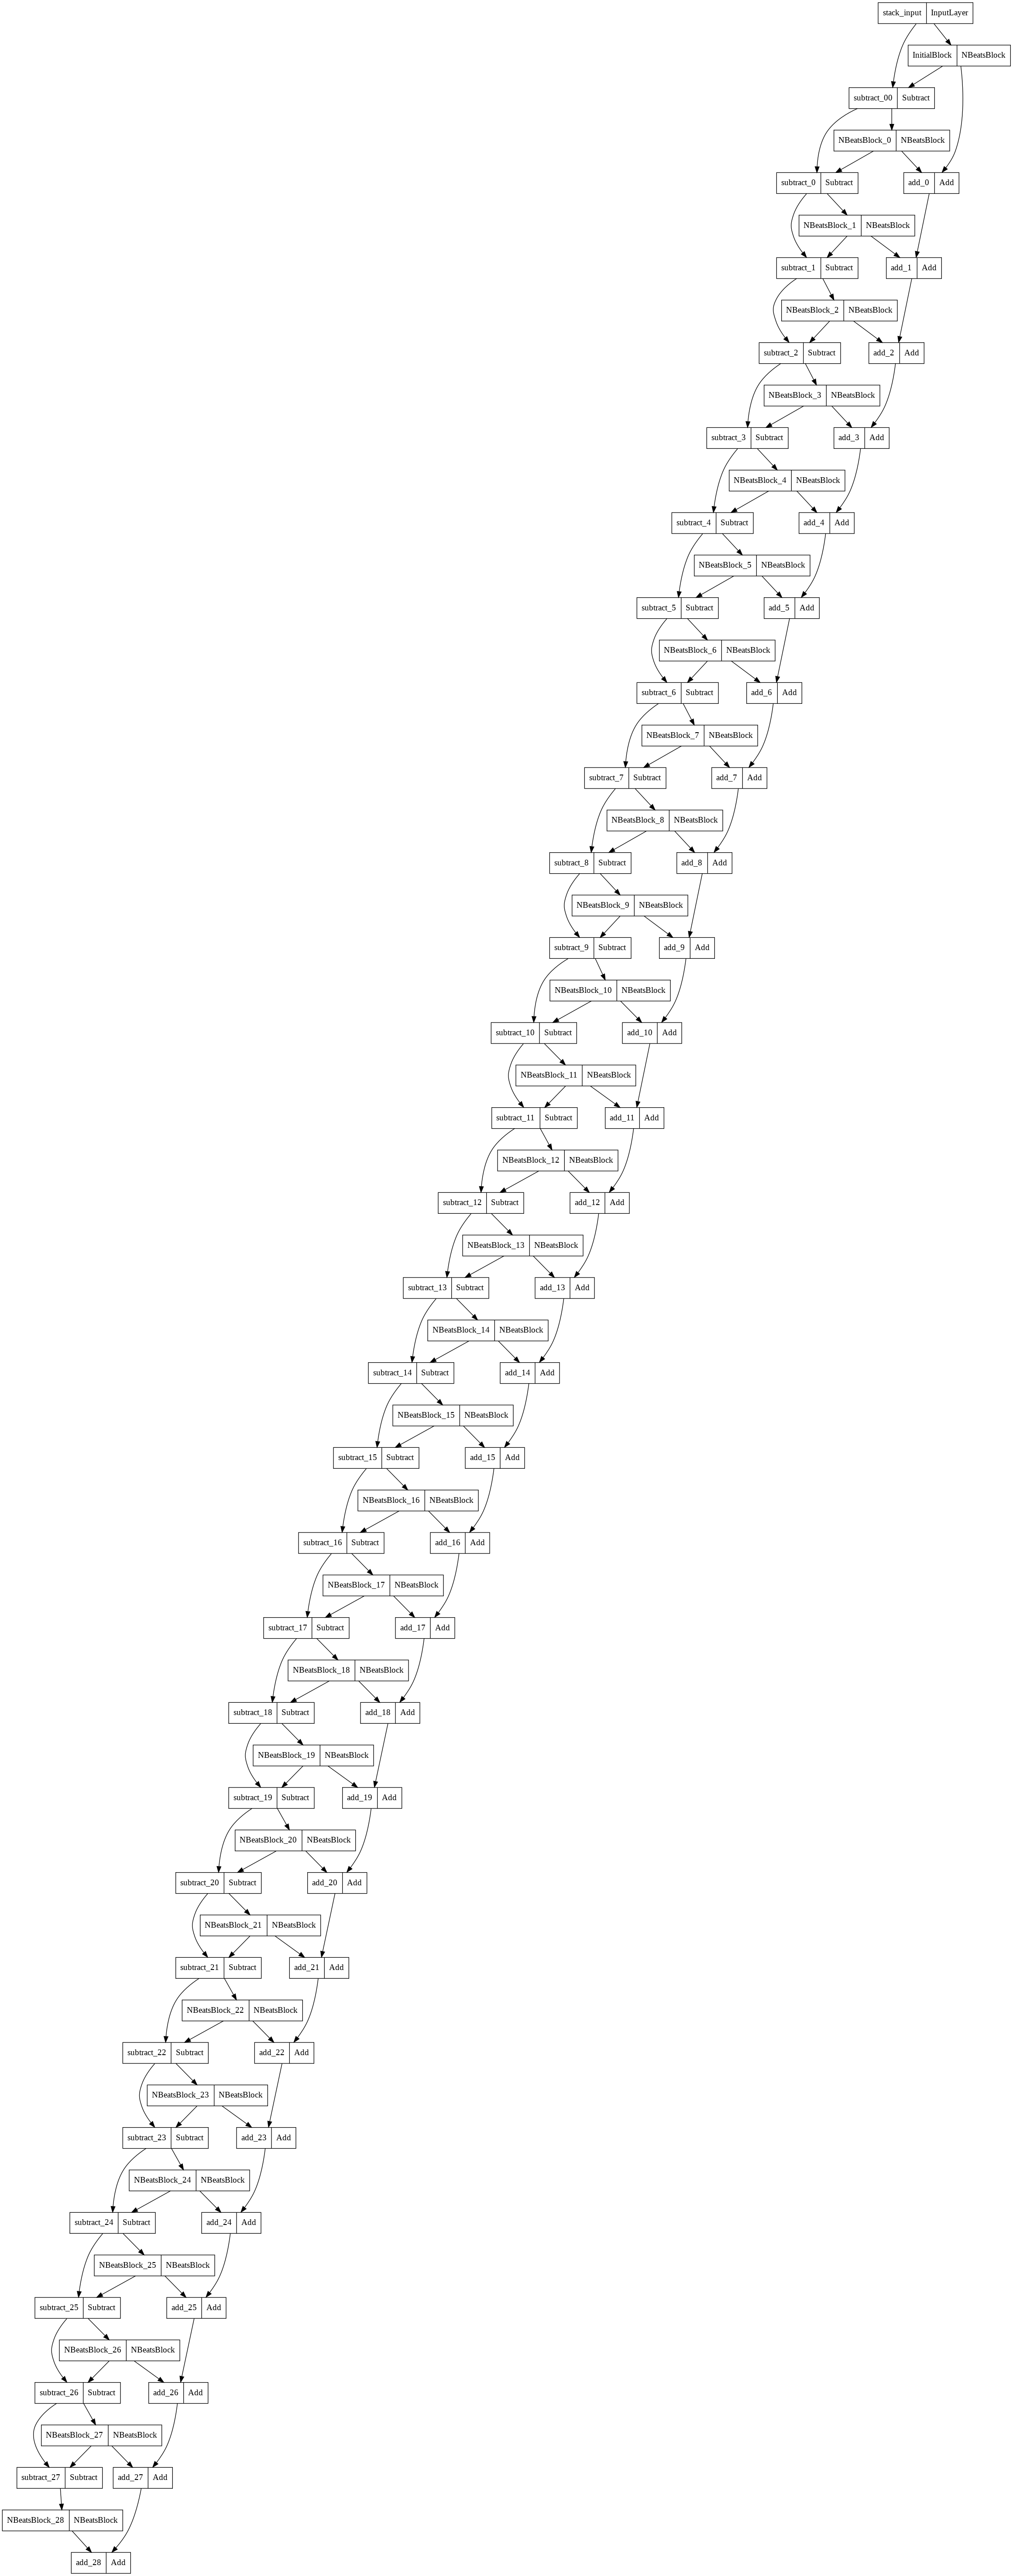

In [112]:
# Plot the N-BEATS model and inspect the architecture
from tensorflow.keras.utils import plot_model
plot_model(model_7)

In [113]:
# save model
model_7.save(model_7.name)

## Model 8: Creating an ensemble (stacking different models together)


An **ensemble** involves training and combining multiple different models on the same problem. 


In the N-BEATS paper, training an ensemble of models  to achieve the results like using a combination of:
  * Different loss functions (sMAPE, MASE and MAPE)
  * Different window sizes (2 x horizon, 3 x horizon, 4 x horizon...)

The benefit of ensembling models is you get the "decision of the crowd effect". Rather than relying on a single model's predictions, ensambling take the average or median of many different models


To create our ensemble models we're going to be using a combination of: 
* Different loss functions (MAE, MSE, MAPE)
* Randomly initialized models



### Constructing and fitting an ensemble of models (using different loss functions)

In [114]:
def get_ensemble_models(horizon=HORIZON, 
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10, 
                        num_epochs=100, 
                        loss_fns=["mae", "mse", "mape"]):
  """
  if num_iter=10, a list of 30 trained models will be returned:
  10 * len(["mae", "mse", "mape"]).
  """
  #  trained ensemble models
  ensemble_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      # simple model (similar to model_1)
      model = tf.keras.Sequential([
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"), 
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(HORIZON)                                 
      ])

      # Compile simple model with current loss function
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae", "mse"])
      
      # Fit model
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                # Add callbacks
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])
      
      # Append fitted model to list of ensemble models
      ensemble_models.append(model)

  return ensemble_models # return list of trained models

In [115]:
%%time
# Get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=1000)

Optimizing model by reducing: mae for 1000 epochs, model number: 0

Epoch 648: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 766: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 866: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 640: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 740: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 131: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 246: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 346: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing: mae for 1000 epochs, model number: 1
Optimizing model by reducing: mse for 1000 epochs, model number: 1

Epoch 338: ReduceLROnPl

In [116]:
# Function which uses a list of trained models to make and return a list of predictions
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data) # make predictions with current ensemble model
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [117]:
# Create a list of ensemble predictions
ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models,
                                     data=test_dataset)
ensemble_preds

1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 39ms/step


<tf.Tensor: shape=(15, 556), dtype=float32, numpy=
array([[ 8813.542,  8792.497,  9032.763, ..., 50166.402, 49166.39 ,
        46571.344],
       [ 8780.977,  8750.089,  8998.269, ..., 49229.004, 48610.004,
        45505.49 ],
       [ 8746.472,  8719.419,  9093.04 , ..., 49876.074, 47759.37 ,
        45164.566],
       ...,
       [ 8828.827,  8753.614,  9091.938, ..., 49431.793, 49433.047,
        46267.63 ],
       [ 8735.042,  8809.727,  9110.055, ..., 49637.605, 48578.027,
        45071.465],
       [ 8808.815,  8779.743,  9024.745, ..., 49918.586, 48223.098,
        45665.78 ]], dtype=float32)>

In [118]:
# Evaluate ensemble model(s) predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=np.median(ensemble_preds, axis=0)) # take the median across all ensemble predictions
ensemble_results

{'mae': 567.01556,
 'mse': 1147199.2,
 'rmse': 1071.0739,
 'mape': 2.5760603,
 'mase': 0.9960893}

Ensemble model is the best performing model on the MAE metric so far.

### Prediction intervals of ensemble

Prediction intervals or uncertainty estimates:

Right now all of our model's (prior to the ensemble model) are predicting single points. 

For given a set of `WINDOW_SIZE=7` values, the model will predict `HORIZION=1`. This can be called **point prediction**, or single value in time)

But what about predictiong a range of values?

If a model is predicting the price of Bitcoin to be 50,000USD tomorrow, would it be helpful to know it's predicting the 50,000USD because it's predicting the price to be between 48,000 and 52,000USD?

Point prediction model is predicting 50,000USD but the value could actually be within the range 48,000USD to 52,000USD or may be outside of the range.

These kind of prediction ranges are called **prediction intervals** or **uncertainty estimates**.

Because **point predictions** are almost always going to be wrong, having a range of values can help with decision making.



95% condfidence prediction intervals for a deep learning model using bootstrap method: 

1. Take the predictions from a number of randomly initialized models (ensemble model)

2. Measure the standard deviation of the predictions

3. Multiply standard deviation by [1.96](assuming the distribution is Gaussian, 95% of observations fall within 1.96 standard deviations of the mean, this is why we initialized our neural networks with a normal distribution)

4. To get the prediction interval upper and lower bounds, add and subtract the value obtained in (3) to the mean/median of the predictions made in (1)


In [119]:
# Upper and lower bounds of ensemble predictions
def get_upper_lower(preds): # 1. Take the predictions of multiple randomly initialized deep learning neural networks
  
  # Standard deviation of the predictions
  std = tf.math.reduce_std(preds, axis=0)
  
  # 3. Multiply the standard deviation by 1.96
  interval = 1.96 * std

  # Prediction interval upper and lower bounds
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval
  return lower, upper

# Upper and lower bounds of the 95% 
lower, upper = get_upper_lower(preds=ensemble_preds)

'\nPlots:\n1. The test data (the ground truth Bitcoin prices)\n2. The median of the ensemble predictions \n3. The 95% prediction intervals \n'

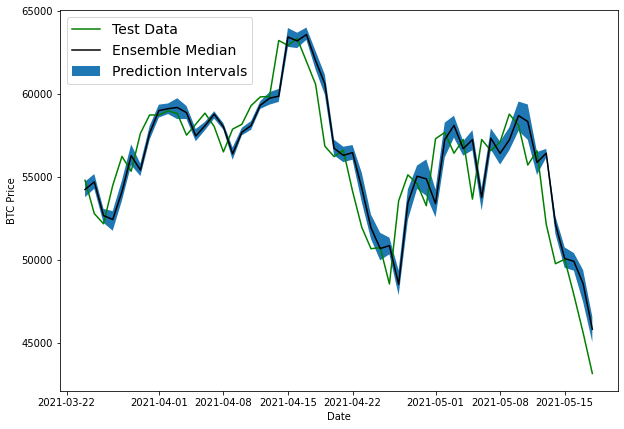

In [120]:
# Plotting Prediction intervals

# Get the median values of our ensemble preds
ensemble_median = np.median(ensemble_preds, axis=0)

# Plot the median of our ensemble preds along with the prediction intervals

offset=500
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.fill_between(X_test.index[offset:], 
                 (lower)[offset:], 
                 (upper)[offset:], label="Prediction Intervals")
plt.legend(loc="upper left", fontsize=14);



"""
Plots:
1. The test data (the ground truth Bitcoin prices)
2. The median of the ensemble predictions 
3. The 95% prediction intervals 
"""

Ensemble predictions are lagging slightly behind the actual data and prediction intervals are low.

The combination of lagging predictions as well as low prediction intervals indicates that our ensemble model may be **overfitting** the data


## Model 9: Train a model on the full historical data to make predictions into future

creating a model which is able to make future predictions on the price of Bitcoin.

In [121]:
bitcoin_prices_windowed.head()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [122]:
# Train model on entire data to make prediction for the next day 
X_all = bitcoin_prices_windowed.drop(["Price", "block_reward"], axis=1).dropna().to_numpy()
y_all = bitcoin_prices_windowed.dropna()["Price"].to_numpy()

In [123]:
# X and y into tensor Datasets
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# Combine features & labels
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# Batch and prefetch for optimal performance
BATCH_SIZE = 1024 
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [124]:
tf.random.set_seed(42)

# Create model
model_9 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
])

# Compile
model_9.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam())

# Fit model on all of the data 
model_9.fit(dataset_all,
            epochs=100,
            verbose=0)

### Make predictions on the future

In [169]:
# How many timesteps to predict into the future?
INTO_FUTURE = 14 # since our Bitcoin data is daily, this is for 14 days

In [170]:
# Function to make predictions into the future
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  
  
  future_forecast = []
  last_window = values[-WINDOW_SIZE:] # Preds from the last window

  # INTO_FUTURE number of predictions
  for _ in range(into_future):
    
    # Predict on last window then append it repeatedly

    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")
    
    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())
    # print(future_forecast)

    # Update last window with new pred
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  
  return future_forecast

In [171]:
future_forecast = make_future_forecast(values=y_all,
                                       model=model_9,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

1/1 [==============================] - 0s 30ms/step
Predicting on: 
 [56573.5554719  52147.82118698 49764.1320816  50032.69313676
 47885.62525472 45604.61575361 43144.47129086] -> Prediction: 55881.53125

1/1 [==============================] - 0s 23ms/step
Predicting on: 
 [52147.82118698 49764.1320816  50032.69313676 47885.62525472
 45604.61575361 43144.47129086 55881.53125   ] -> Prediction: 51063.06640625

1/1 [==============================] - 0s 18ms/step
Predicting on: 
 [49764.1320816  50032.69313676 47885.62525472 45604.61575361
 43144.47129086 55881.53125    51063.06640625] -> Prediction: 48624.88671875

1/1 [==============================] - 0s 24ms/step
Predicting on: 
 [50032.69313676 47885.62525472 45604.61575361 43144.47129086
 55881.53125    51063.06640625 48624.88671875] -> Prediction: 48238.29296875

1/1 [==============================] - 0s 19ms/step
Predicting on: 
 [47885.62525472 45604.61575361 43144.47129086 55881.53125
 51063.06640625 48624.88671875 48238.2929687

In [172]:
future_forecast

[55881.53,
 51063.066,
 48624.887,
 48238.293,
 48016.418,
 47004.75,
 48464.332,
 54163.51,
 49864.21,
 47810.637,
 48372.215,
 49084.75,
 48913.086,
 50547.562]

### Plot future forecasts


In [129]:
def get_future_dates(start_date, into_future, offset=1):
 
  start_date = start_date + np.timedelta64(offset, "D") # specify start date, "D" : day
  end_date = start_date + np.timedelta64(into_future, "D") # specify end date
  return np.arange(start_date, end_date, dtype="datetime64[D]") # return a date range between start date and end date

The start date of forecasted dates will be the last date of dataset. 

In [130]:
# Last timestep of timesteps 
last_timestep = bitcoin_prices.index[-1]
last_timestep

Timestamp('2021-05-18 00:00:00')

In [173]:
# Next two weeks of timesteps
next_time_steps = get_future_dates(start_date=last_timestep, 
                                   into_future=INTO_FUTURE)
next_time_steps


array(['2021-05-19', '2021-05-20', '2021-05-21', '2021-05-22',
       '2021-05-23', '2021-05-24', '2021-05-25', '2021-05-26',
       '2021-05-27', '2021-05-28', '2021-05-29', '2021-05-30',
       '2021-05-31', '2021-06-01'], dtype='datetime64[D]')

In [174]:
# Insert last timestep/final price
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, btc_price[-1])
next_time_steps, future_forecast

(array(['2021-05-18', '2021-05-19', '2021-05-20', '2021-05-21',
        '2021-05-22', '2021-05-23', '2021-05-24', '2021-05-25',
        '2021-05-26', '2021-05-27', '2021-05-28', '2021-05-29',
        '2021-05-30', '2021-05-31', '2021-06-01'], dtype='datetime64[D]'),
 array([43144.473, 55881.53 , 51063.066, 48624.887, 48238.293, 48016.418,
        47004.75 , 48464.332, 54163.51 , 49864.21 , 47810.637, 48372.215,
        49084.75 , 48913.086, 50547.562], dtype=float32))

In [175]:
btc_price = bitcoin_prices.copy()
btc_price = btc_price["Price"].tolist()
btc_price[-1]

43144.4712908603

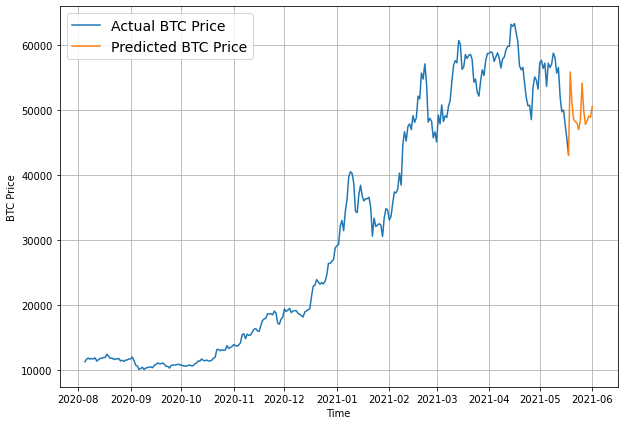

In [176]:
# Plot future price predictions of Bitcoin
plt.figure(figsize=(10, 7))
plot_time_series(bitcoin_prices.index, btc_price, start=2500, format="-", label="Actual BTC Price")
plot_time_series(next_time_steps, future_forecast, format="-", label="Predicted BTC Price")

It looks like our predictions are starting to form a bit of a cyclic pattern (up and down in the same way).

Perhaps our model overfitting the training data and not generalizing well for future data.

 Also, further you predict into the future, the higher your chance for error.

## Model_9 :The turkey problem

The **turkey problem** is an analogy for when your observational data (historical data) fails to capture a future event which is catostrophic and could lead you to ruin.

The story goes, a turkey lives a good life for 1000 days, being fed every day and taken care of by its owners until the evening before Thanksgiving.
Based on the turkey's observational data, it has no reason to believe things shouldn't keep going the way they are. how could a turkey possibly predict that on day 1001, after 1000 consectutive good days, it was about to have a far from ideal day.


How does this relate to predicting the price of Bitcoin? You could have the historical data of Bitcoin for its entire existence and build a model which predicts it perfectly. But then one day for some unknown and unpredictable reason, the price of Bitcoin plummets 100x in a single day. The same thing goes for predicting the price of Bitcoin, you could make money for 10-years straight and then lose it all in a single day.

Let's see how the turkey problem effects us modelling the historical and future price of Bitcoin.


In [180]:
btc_price_turkey = btc_price.copy()
btc_price_turkey[-10:]

[58788.2096789273,
 58102.1914262342,
 55715.5466512869,
 56573.5554719043,
 52147.8211869823,
 49764.1320815975,
 50032.6931367648,
 47885.6252547166,
 45604.6157536131,
 43144.4712908603]

In [181]:
# Turkey problem to our BTC data (price BTC falls 100x in one day)
btc_price_turkey = btc_price.copy()
btc_price_turkey[-1] = btc_price_turkey[-1] / 100
btc_price_turkey[-1]

431.44471290860304

In [182]:
# Manufacture an extra price on the end 
btc_price_turkey[-10:]

[58788.2096789273,
 58102.1914262342,
 55715.5466512869,
 56573.5554719043,
 52147.8211869823,
 49764.1320815975,
 50032.6931367648,
 47885.6252547166,
 45604.6157536131,
 431.44471290860304]

In [183]:
# Get the timesteps for the turkey problem 
btc_timesteps_turkey = np.array(bitcoin_prices.index)
btc_timesteps_turkey[-10:]

array(['2021-05-09T00:00:00.000000000', '2021-05-10T00:00:00.000000000',
       '2021-05-11T00:00:00.000000000', '2021-05-12T00:00:00.000000000',
       '2021-05-13T00:00:00.000000000', '2021-05-14T00:00:00.000000000',
       '2021-05-15T00:00:00.000000000', '2021-05-16T00:00:00.000000000',
       '2021-05-17T00:00:00.000000000', '2021-05-18T00:00:00.000000000'],
      dtype='datetime64[ns]')

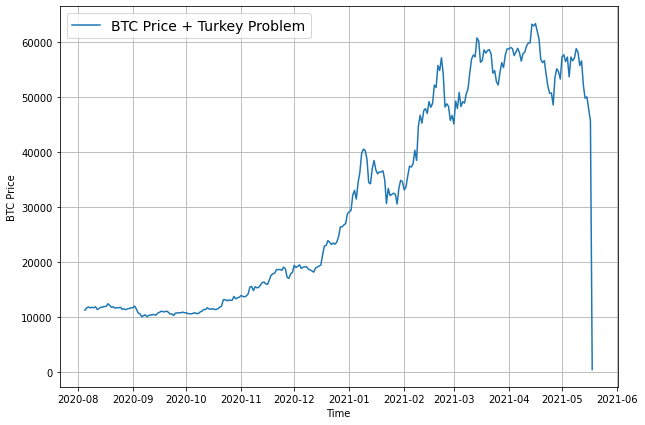

In [184]:
#plot
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=btc_timesteps_turkey, 
                 values=btc_price_turkey, 
                 format="-", 
                 label="BTC Price + Turkey Problem", 
                 start=2500)

In [185]:
# Create train and test sets for turkey problem data
full_windows, full_labels = make_windows(np.array(btc_price_turkey), window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

X_train, X_test, y_train, y_test = make_train_test_splits(full_windows, full_labels)
len(X_train), len(X_test), len(y_train), len(y_test)

(2224, 556, 2224, 556)

### Building a turkey model (model to predict on turkey data)



In [186]:
# Clone model 1 architecture for turkey model and fit the turkey model on the turkey data
turkey_model = tf.keras.models.clone_model(model_1)
turkey_model._name = "Turkey_Model"
turkey_model.compile(loss="mae",
                     optimizer=tf.keras.optimizers.Adam())
turkey_model.fit(X_train, y_train,
                 epochs=100,
                 verbose=0,
                 validation_data=(X_test, y_test),
                 callbacks=[create_model_checkpoint(turkey_model.name)])

In [187]:
# Evaluate turkey model on test data
turkey_model.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 762.0912


762.0912475585938

In [188]:
# Load best model and evaluate on test data
turkey_model = tf.keras.models.load_model("model_experiments/Turkey_Model/")
turkey_model.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 638.7267


638.7266845703125

In [189]:
# Make predictions with Turkey model
turkey_preds = make_preds(turkey_model, X_test)
turkey_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8833.469, 8776.386, 9021.734, 8776.482, 8765.86 , 8724.67 ,
       8659.346, 8541.15 , 8443.93 , 8521.438], dtype=float32)>

In [190]:
# Evaluate turkey preds
turkey_results = evaluate_preds(y_true=y_test,
                                y_pred=turkey_preds)
turkey_results

{'mae': 17130.854,
 'mse': 614519100.0,
 'rmse': 23716.734,
 'mape': 121.38079,
 'mase': 26.51006}

With just one value change, our error metrics go through the roof.

In [191]:
model_1_results

{'mae': 568.5498,
 'mse': 1172587.4,
 'rmse': 1082.8607,
 'mape': 2.549229,
 'mase': 0.99878454}

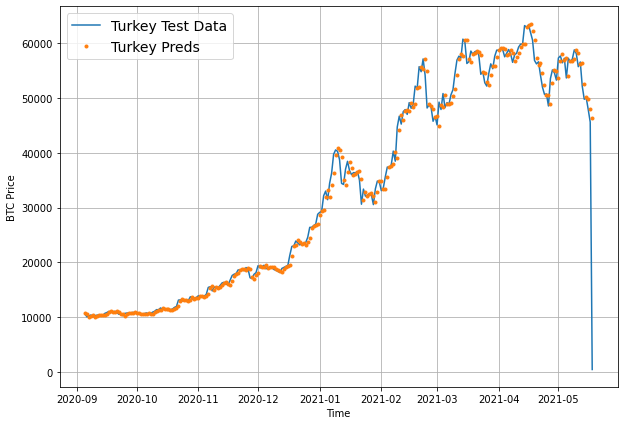

In [192]:
# Plot

plt.figure(figsize=(10, 7))
# plot_time_series(timesteps=btc_timesteps_turkey[:split_size], values=btc_price_turkey[:split_size], label="Train Data")
offset=300
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):], 
                 values=btc_price_turkey[-len(y_test):], 
                 format="-", 
                 label="Turkey Test Data", start=offset)
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):],
                 values=turkey_preds, 
                 label="Turkey Preds", 
                 start=offset);

## Compare Models

In [193]:
# Compare different model results (w = window, h = horizon, e.g. w=7 means a window size of 7)
model_results = pd.DataFrame({"naive_model": naive_results,
                              "model_1_dense_w7_h1": model_1_results,
                              "model_2_dense_w30_h1": model_2_results,
                              "model_3_dense_w30_h7": model_3_results,
                              "model_4_CONV1D": model_4_results,
                              "model_5_LSTM": model_5_results,
                              "model_6_multivariate": model_6_results,
                              "model_8_NBEATs": model_7_results,
                              "model_9_ensemble": ensemble_results,
                              "model_10_turkey": turkey_results}).T
model_results.head(10)

,mae,mse,rmse,mape,mase
naive_model,567.980225,1.147547e+06,1071.236206,2.516525,0.999570
model_1_dense_w7_h1,568.549805,1.172587e+06,1082.860718,2.549229,0.998785
model_2_dense_w30_h1,608.847961,1.284314e+06,1133.275513,2.768065,1.064272
model_3_dense_w30_h7,1236.207520,5.459194e+06,1421.614258,5.590653,2.199762
model_4_CONV1D,569.032715,1.169841e+06,1081.592041,2.551526,0.999633
model_5_LSTM,592.967346,1.248880e+06,1117.533203,2.661356,1.041679
model_6_multivariate,567.829163,1.163728e+06,1078.761963,2.546015,0.997519
model_8_NBEATs,570.575867,1.162314e+06,1078.106812,2.591371,1.002344
model_9_ensemble,567.015564,1.147199e+06,1071.073853,2.576060,0.996089
model_10_turkey,17130.853516,6.145191e+08,23716.734375,121.380791,26.510059


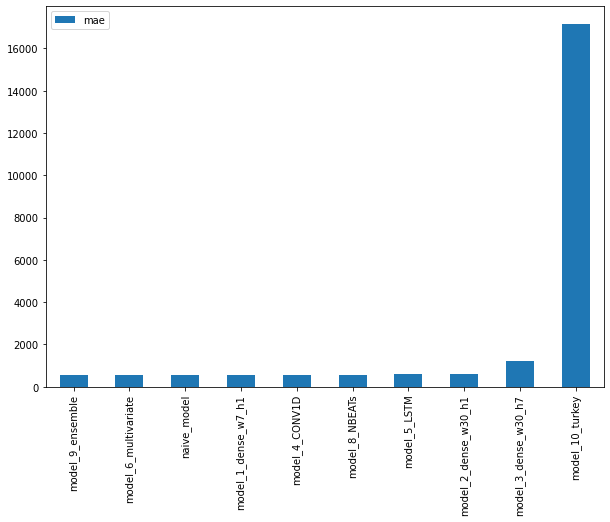

In [194]:
# Sort model results by MAE and plot them
model_results[["mae"]].sort_values(by="mae").plot(figsize=(10, 7), kind="bar");